This jupyter notebook shall serve as accompanying material to the paper titled “Studing the CoViD-19 pandemic using space-sensitive compartmental models”, a report for the “Programmable Biology” subject at UPM’s Master in Computational Biology

First, we import the necessary modules:

In [1]:
import numpy as np                  # Supports common numeric operations
import pandas as pd                 # Data management library
import matplotlib.pyplot as plt     # Comprehensive library for creating data visualizations
from matplotlib.lines import Line2D # Create 2D lines from two points
import networkx as nx               # For the creation, manipulation, and study of complex networks.
import scipy.stats as stats         # Stats calculator from SciPy
import epyestim.covid19 as r0_estimator # estimates R0 from a time series of reported case numbers

Some parameters are taking from literature:

In [2]:
delta = 1/3; gamma = 1/9.0; sigma = 1/4.5; tau = 1/14
rho = 1/14; omega = 1/6.5; eta = 1/9.0; UCI_100 = 9.7

And some are estimated in *Alóndiga et al.*. $u$, $a$ and $m$ were modified to better match existing data on deaths:

In [3]:
u = 0.4; m = 0.6; a = 0.25; R_0i = 4.244; s = 0.012;

And a new param, omicron, represents the proportion of individuals that loose inmunity. The mobility treshold was estimated as 10%

In [4]:
omicron = 0.01; mobility = 0.1

We define a function that estimates $b$ over time based on an estimated $R_{0}$, which we will calculate later on.

In [5]:
def b(t):   
    return (estimated_r0["R_mean"][t])* gamma

With regards to UCI beds, we modified the equation to only have them expand until day 300, and then fall to slightly above the base level, as explained in the paper

In [6]:
def UCI(t, N):
    UCI_0 = UCI_100 / 100_000 * N 
    if t < 200: return UCI_0 + s*UCI_0*t
    if t >= 200 and t < 300: return UCI_0 + s*UCI_0*(400-t)
    else: return  UCI_0 + s*UCI_0*100

For our "celular automata", each time step will be defined by the following function:

In [7]:
def time_step(t, S, E, I, H, R, C, M):
    N = S + E + I + H + R + C + M 
    
    dE = b(t) * S * I / N - delta * E   
    dI = delta * E - I*eta*a - I*gamma*(1-a)
    dH = eta*a*I-tau*(1-u)*H-u*sigma*H
    dC = u*sigma*H - m*rho*min(UCI(t, N),C) - max(0,C-UCI(t, N))-omega*(1-m)*min(UCI(t, N),C)
    dM = m*rho*min(UCI(t, N),C) + max(0,C-UCI(t, N))
    
    if t <= 180: # Waning inmunity after 180 days
        dS = -b(t) * S * I / N 
        dR = I*gamma*(1-a) + tau*(1-u)*H + omega*(1-m)*min(UCI(t, N),C)
    else: # A proportion of recovered become susceptible again
        dS = -b(t) * S * I / N + R*omicron
        dR = I*gamma*(1-a) + tau*(1-u)*H + omega*(1-m)*min(UCI(t, N),C) - R*omicron 

    return [ round(x) for x in [dS, dE, dI, dH, dR, dC, dM] ] 

Now, we can proceed with the simulation itself. First, we import a pre-prepared dataframe with some data and some columns, where we will store our lists of cases. This, by the way, [is not good practice according to Pandas devs](https://github.com/pandas-dev/pandas/issues/12663#issuecomment-198067862), and should be improved. 

In [8]:
df = pd.read_csv('./population_values.csv', header=0)
df['S'] = df['S'].apply(lambda d: d if isinstance(d, list) else [])
df['E'] = df['E'].apply(lambda d: d if isinstance(d, list) else [])
df['I'] = df['I'].apply(lambda d: d if isinstance(d, list) else [])
df['H'] = df['H'].apply(lambda d: d if isinstance(d, list) else [])
df['R'] = df['R'].apply(lambda d: d if isinstance(d, list) else [])
df['C'] = df['C'].apply(lambda d: d if isinstance(d, list) else [])
df['M'] = df['M'].apply(lambda d: d if isinstance(d, list) else [])
df['Casos Reales'] = df['Casos Reales'].apply(lambda d: d if isinstance(d, list) else [])

To compare the real casecounts, we will import a "ground truth" table and preprocess it to have our chosen format.

In [9]:
# First, we import the data
raw_database = pd.read_csv('./casos_provincia.csv', header=0)

# We use a dictionary to get the right province name. This was *a-pain* to code, and Navarra doesnt
# work somehow, but since we are not using it in our simulations, no problem :D
raw_database.replace({"A":"Alicante", "AB":"Albacete", "AL":"Almería", "AV":"Ávila", "B":"Barcelona",
                      "BA":"Badajoz", "BI":"Vizcaya", "BU":"Burgos", "C":"A Coruña", "CA":"Cádiz", "CC":"Cáceres",
                      "CO":"Córdoba", "CR":"Ciudad Real", "CS":"Castellón", "CU":"Cuenca", "GC":"Las Palmas",
                      "GI":"Gerona", "GR":"Granada", "GU":"Guadalajara", "H":"Huelva","VI":"Álaba", "HU":"Huesca",
                      "J":"Jaen", "L":"Lérida", "LE":"León", "LO":"La Rioja", "LU":"Lugo", "M":"Madrid", "MA":"Málaga",
                      "MU":"Murcia", "NA":"Navarra", "O":"Asturias", "OR":"Ourense", "P":"Palencia", "PM":"Baleares",
                      "PO":"Pontevedra", "S":"Cantabria", "SA":"Salamanca", "SE":"Sevilla", "SO":"Soria", 
                      "SS":"Guipúzcoa", "T":"Tarragona", "TE":"Teruel", "TF":"Santa Cruz de Tenerife", "TO":"Toledo",
                      "V":"Valencia", "VA":"Valladolid", "VI":"Álava", "Z":"Zaragoza", "ZA":"Zamora",
                      "ML":"Melilla", "CE":"Ceuta", "NC":"Comunidad de Navarra"}, inplace=True) 

# We remove the provinces we dont care about
raw_database = raw_database[raw_database["provincia_iso"].isin(df["Provincia"])]

# And get the data in our desired format, saving it on the original df
for fecha in raw_database["fecha"].unique():
    database_fecha = raw_database.loc[raw_database["fecha"] == fecha]
    for provincia in database_fecha['provincia_iso']:
        index_df = int(df[df["Provincia"] == provincia].index.values)
        index_db_fecha = int(database_fecha[database_fecha["provincia_iso"] == provincia].index.values)
        df["Casos Reales"][index_df].append(database_fecha['num_casos'][index_db_fecha])

We seed the simulation, setting February 20th, 2020 as day 0

In [10]:
for i in range(len(df)): 
    
    # For our simulation to work, we need to initialize all vectors for Day 0
    df['S'][i].append(df['Poblacion'][i]); df["E"][i].append(0); df["H"][i].append(0)
    df["I"][i].append(0); df["R"][i].append(0); df["C"][i].append(0); df["M"][i].append(0)
    
    # Once initialized, we set all values for Day 0: February 20th, 2020
    df["I"][i][0] = df["Casos Reales"][i][50];
    df["S"][i][0] -= df["Casos Reales"][i][50];
    
    # And we use that value to update the "exposed" compartment using R0
    df["E"][i][0] = round(R_0i * df["I"][i][0])
    df["S"][i][0] -= round(R_0i * df["I"][i][0])

We sum up the real cases and create a dataframe to feed to epyestim, which estimates $R_{0}$

In [11]:
casos_totales = []
for t in range(len(df["Casos Reales"][0])):
    for i in range(len(df)):
        if i == 0: casos_totales.append(df["Casos Reales"][i][t])
        else: casos_totales[t] += df["Casos Reales"][i][t]
            
casos_totales = pd.DataFrame({"Cases":casos_totales, "Date":raw_database["fecha"].unique()})
casos_totales["Date"] = pd.to_datetime(casos_totales['Date'])
casos_totales = casos_totales.set_index('Date')['Cases']

estimated_r0 = r0_estimator.r_covid(casos_totales)[31:]
original_avg_r0 = sum(estimated_r0["R_mean"])/len(estimated_r0["R_mean"]) 

We create a graph to represent neighbors, as explained in the paper.

In [12]:
# To work with neighbors in our graph simulation, we import the adjacency matrix described in the paper
adjacency_matrix = np.loadtxt("./adjacency_matrix.csv", delimiter=",")
graph = nx.from_numpy_matrix(adjacency_matrix) 

We generate a new dataframe to compare the neighbored-model to one without mobility, using apply as a cheat because using a pd.DataFrame to save things was a bad idea:

In [13]:
new_df = df.copy(); new_df['M'] = new_df.M.apply(list.copy)
new_df['S'] = df.S.apply(list.copy); new_df['E'] = df.E.apply(list.copy); new_df['I'] = df.I.apply(list.copy);
new_df['H'] = df.H.apply(list.copy); new_df['R'] = df.R.apply(list.copy); new_df['C'] = df.C.apply(list.copy);

And we proceed with the simulations!

In [14]:
for t in range(677):  # For each time step
    
    # First, we modify slightly the R_0, since predictions didnt match reality very well
    if t < 20: estimated_r0["R_mean"][t] = 4.5
    if t > 310 and t < 350: estimated_r0["R_mean"][t]+=0.2
    if t > 360 and t < 400: estimated_r0["R_mean"][t]-=0.5
    if t > 490 and t < 520: estimated_r0["R_mean"][t]+=0.55
    if t > 550 and t < 590: estimated_r0["R_mean"][t]-=0.25
    if t > 650: estimated_r0["R_mean"][t] = 0.1666*t - 107.33
        
    for i in range(len(df)): # Update the values for each city:
        
        #First, we get the change in each compartment for an scenario with mobility
        diffs = time_step(t, df["S"][i][t], df["E"][i][t], df["I"][i][t], df["H"][i][t], 
                          df["R"][i][t], df["C"][i][t], df["M"][i][t])
       
        #And we update the new generation
        df["S"][i].append(df["S"][i][t]+diffs[0]);       df["E"][i].append(df["E"][i][t]+diffs[1]); 
        df["I"][i].append(df["I"][i][t]+diffs[2]);       df["H"][i].append(df["H"][i][t]+diffs[3]); 
        df["R"][i].append(df["R"][i][t]+diffs[4]);       df["C"][i].append(df["C"][i][t]+diffs[5])
        df["M"][i].append(df["M"][i][t]+diffs[6])
        
        # We can repeat the modelling for a no-mobility scenario
        new_diffs = time_step(t, new_df["S"][i][t], new_df["E"][i][t], new_df["I"][i][t], new_df["H"][i][t], 
                              new_df["R"][i][t], new_df["C"][i][t], new_df["M"][i][t])
       
        #And update the new generation
        new_df["S"][i].append(new_df["S"][i][t]+new_diffs[0]);   new_df["E"][i].append(new_df["E"][i][t]+new_diffs[1]); 
        new_df["I"][i].append(new_df["I"][i][t]+new_diffs[2]);   new_df["H"][i].append(new_df["H"][i][t]+new_diffs[3]); 
        new_df["R"][i].append(new_df["R"][i][t]+new_diffs[4]);   new_df["C"][i].append(new_df["C"][i][t]+new_diffs[5])
        new_df["M"][i].append(new_df["M"][i][t]+new_diffs[6])
        
        # ------ At the end of the day, we count the influence of voyages started last day  ------- #
    
    for i in range(len(df)):
        m_df = df.copy();
        m_df['S'] = df.S.apply(list.copy); m_df['E'] = df.E.apply(list.copy); m_df['I'] = df.I.apply(list.copy);
        m_df['H'] = df.H.apply(list.copy); m_df['R'] = df.R.apply(list.copy); m_df['C'] = df.C.apply(list.copy);
    
        population_neighbors = 0 # Count how many neighbors a city has
        for neighbor in graph.neighbors(i):             # First we figure out how many neighbors we have
            alive_neighbor = (m_df["S"][neighbor][t] + m_df["E"][neighbor][t] + m_df["I"][neighbor][t] + 
                              m_df["H"][neighbor][t] + m_df["R"][neighbor][t] + m_df["C"][neighbor][t])
            population_neighbors += alive_neighbor
        
        alive_here = (m_df["S"][i][t] + m_df["E"][i][t] + m_df["I"][i][t] 
                      + m_df["H"][i][t] + m_df["R"][i][t] + m_df["C"][i][t])
        
        # Each city will exchange a ```mobility``` % of its population to its neighbors
        # The M compartment is excluded: dead people do not move!
        df["S"][i][t] -= round(df["S"][i][t]*mobility);     df["E"][i][t] -= round(df["E"][i][t]*mobility)
        df["I"][i][t] -= round(df["I"][i][t]*mobility);     df["H"][i][t] -= round(df["H"][i][t]*mobility)
        df["R"][i][t] -= round(df["R"][i][t]*mobility);     df["C"][i][t] -= round(df["C"][i][t]*mobility)
        
        # For each neighor of each city
        for neighbor in graph.neighbors(i):    
            
            # We calculate the proportion of individuals to send from each compartment
            population_sent = ((alive_here*mobility) # Population that moves
                               *(alive_neighbor) # Population alive @ neighbor X
                               /(population_neighbors)) # Alive population at all neighors
            proportion_sent  = population_sent /alive_neighbor
            
            # And send them to each city
            df["S"][i][t] += round(m_df["S"][neighbor][t]*proportion_sent) 
            df["E"][i][t] += round(m_df["E"][neighbor][t]*proportion_sent) 
            df["I"][i][t] += round(m_df["I"][neighbor][t]*proportion_sent) 
            df["H"][i][t] += round(m_df["H"][neighbor][t]*proportion_sent)
            df["R"][i][t] += round(m_df["R"][neighbor][t]*proportion_sent) 
            df["C"][i][t] += round(m_df["C"][neighbor][t]*proportion_sent)
        
        # ----------------------------------------------------------------------------------------- #

To check how our model went, we sum up all the infected values to compare with the ground truth

In [15]:
infectados_totales = []
for t in range(len(df["I"][0])):
    for i in range(len(df)):
        if i == 0: infectados_totales.append(df["I"][i][t])
        else: infectados_totales[t] += df["I"][i][t]
            
altered_avg_r0 = sum(estimated_r0["R_mean"])/len(estimated_r0["R_mean"]) 

new_infectados_totales = []
for t in range(len(new_df["I"][0])):
    for i in range(len(new_df)):
        if i == 0: new_infectados_totales.append(new_df["I"][i][t])
        else: new_infectados_totales[t] += new_df["I"][i][t]  

n_i_t = new_infectados_totales; i_t = infectados_totales
correction = abs(round(100*(original_avg_r0-altered_avg_r0)/original_avg_r0, 2))

In [16]:
print(f"The R² for the non mobility scenario was {stats.linregress(n_i_t,casos_totales[50:-10]).rvalue**2}")
print(f"The R² for the mobility scenario was {stats.linregress(i_t,casos_totales[50:-10]).rvalue**2}")
print(f"Total cases for the non mobility scenario: {sum(n_i_t)}")
print(f"Total cases for the mobility scenario: {sum(i_t)}")
print(f"The % modification on R₀ was {correction} %")

The R² for the non mobility scenario was 0.7301031356104851
The R² for the mobility scenario was 0.7298519713759262
Total cases for the non mobility scenario: 3879291
Total cases for the mobility scenario: 4002447
The % modification on R₀ was 11.96 %


Now, its plotting time!

First, we plot the predictions for infections vs the ground truth:

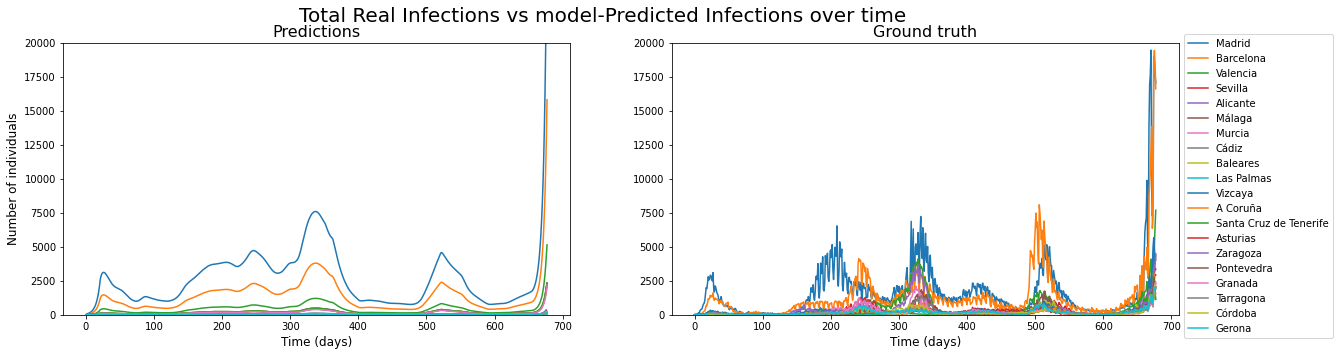

In [17]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

# Set titles
fig.suptitle('Total Real Infections vs model-Predicted Infections over time', size=20)
ax[0].set_title('Predictions', size=16); ax[1].set_title('Ground truth', size=16)

# We plot all infections, both from our predictions and from our "ground truth" data
for i in range(len(df)):
    ax[1].set_ylim(0,20000); ax[0].set_ylim(0,20000)
    ax[1].plot(range(678), df['Casos Reales'][i][52:-8], label=f"{df['Provincia'][i]}")
    ax[0].plot(range(678), df['I'][i], label=f"{df['Provincia'][i]}")
    
ax[0].set_ylabel("Number of individuals", size=12); # Set axis labels
ax[0].set_xlabel("Time (days)", size=12); ax[1].set_xlabel("Time (days)", size=12)

plt.legend(bbox_to_anchor=(1,1.05), loc="upper left") # Plot legend
plt.savefig("./infected.png", dpi=400)

This can also be done in a cumulative way, province-by-province:

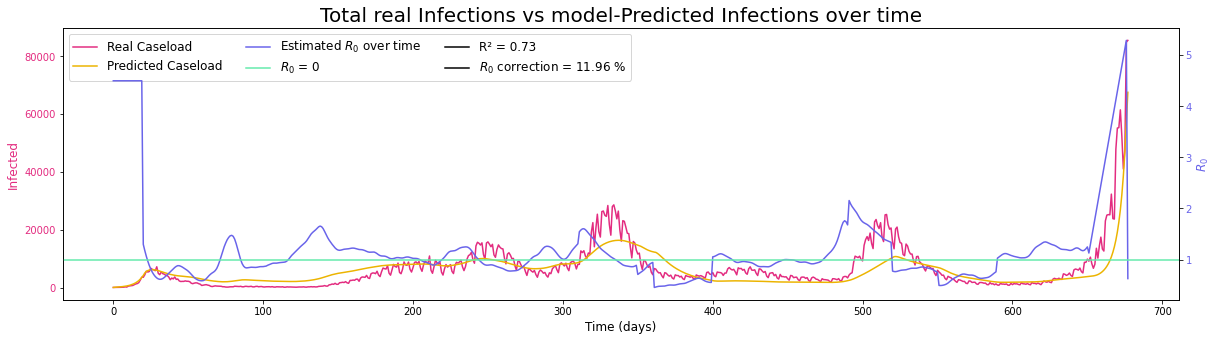

In [18]:
fig, ax = plt.subplots(1,1, figsize=(20,5))

ax.set_title('Total real Infections vs model-Predicted Infections over time', size=20)

# First plot
ax.set_xlabel("Time (days)", size=12); 
ax.plot(range(len(casos_totales[50:-10])), casos_totales[50:-10], '-', label='Real Caseload', color = "#E32C80")
ax.plot(range(len(casos_totales[50:-10])), infectados_totales, '-', label='Predicted Caseload', color = "#ecb400")
ax.set_ylabel("Infected", color="#E32C80", size=12)
ax.tick_params(axis='y', labelcolor="#E32C80")

res = stats.linregress(infectados_totales,casos_totales[50:-10])
correction = abs(round(100*(original_avg_r0-altered_avg_r0)/original_avg_r0, 2))

# Second plot
ax1 = ax.twinx() #Should be done in the same fig
ax1.plot(range(len(casos_totales[50:-10])), estimated_r0["R_mean"], '-', 
         label='Estimated $R_{0}$ over time', color = "#6964EA")
ax1.tick_params(axis='y', labelcolor="#6964EA")
ax1.axhline(y=1,color="#64EAAC", label = "$R_{0}$ = 0")
ax1.set_ylabel("$R_{0}$", color="#6964EA", size=12)

# Custom legend colors
custom_legend = [Line2D([0], [0], color="#E32C80"), Line2D([0], [0], color="#ecb400"),
                Line2D([0], [0], color="#6964EA"), Line2D([0], [0], color="#64EAAC"), 
                Line2D([0], [0], color="black"), Line2D([0], [0], color="black")]

# Custom legend labels
ax.legend(custom_legend, ['Real Caseload', 'Predicted Caseload', 'Estimated $R_{0}$ over time', 
                          '$R_{0}$ = 0', f'R² = {round(res.rvalue**2, 3)}', 
                          f'$R_{0}$ correction = {correction} %'], ncol=3, prop=dict(size=12))

plt.savefig("./infections-over-time.png", dpi=500)

We can also plot the Susceptible and Recovered compartments:

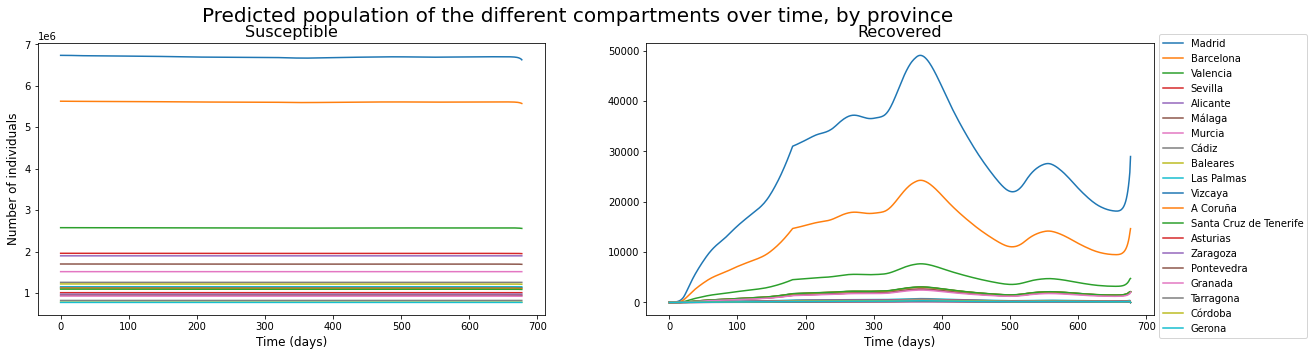

In [19]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

# Set titles
fig.suptitle('Predicted population of the different compartments over time, by province', size=20)
ax[0].set_title('Susceptible', size=16); ax[1].set_title('Recovered', size=16)

# We plot all infections, both from our predictions and from our "ground truth" data
for i in range(len(df)):
    ax[0].plot(range(678), df['S'][i], label=f"{df['Provincia'][i]}")
    ax[1].plot(range(678), df['R'][i], label=f"{df['Provincia'][i]}")
    
ax[0].set_ylabel("Number of individuals", size=12); # Set axis labels
ax[0].set_xlabel("Time (days)", size=12); ax[1].set_xlabel("Time (days)", size=12)

plt.legend(bbox_to_anchor=(1,1.05), loc="upper left") # Plot legend
plt.savefig("./susceptible-recovered.png", dpi=400)

And the "bad trio": hospitalizations vs recovery vs death:

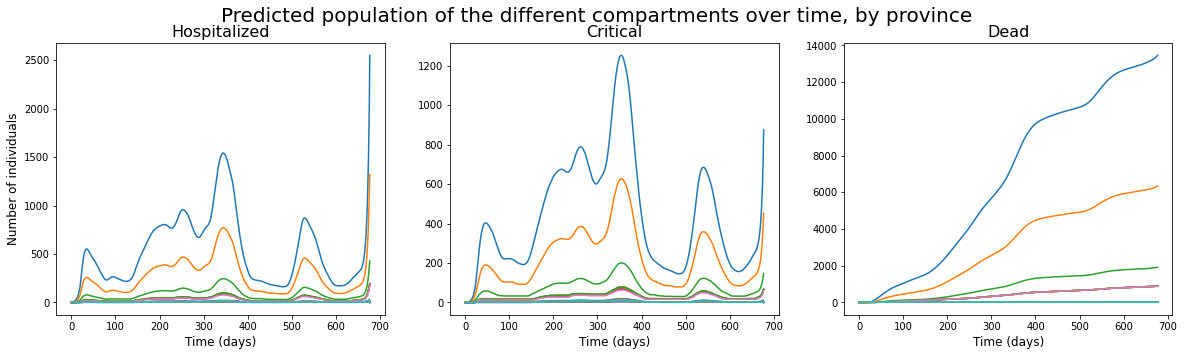

In [20]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

# Set titles
fig.suptitle('Predicted population of the different compartments over time, by province', size=20)
ax[0].set_title('Hospitalized', size=16); ax[1].set_title('Critical', size=16); ax[2].set_title('Dead', size=16)

# We plot all infections, both from our predictions and from our "ground truth" data
for i in range(len(df)):
    ax[0].plot(range(678), df['H'][i], label=f"{df['Provincia'][i]}")
    ax[1].plot(range(678), df['C'][i], label=f"{df['Provincia'][i]}")
    ax[2].plot(range(678), df['M'][i], label=f"{df['Provincia'][i]}")
    
# Set axis labels
ax[0].set_ylabel("Number of individuals", size=12); ax[0].set_xlabel("Time (days)", size=12)
ax[1].set_xlabel("Time (days)", size=12); ax[2].set_xlabel("Time (days)", size=12)

plt.savefig("./hospitalized-critical-dead.png", dpi=400)

The "exposed" compartment we plotted by itself, because it shows weird behaviour: I see too little exposed people for the number of infections.

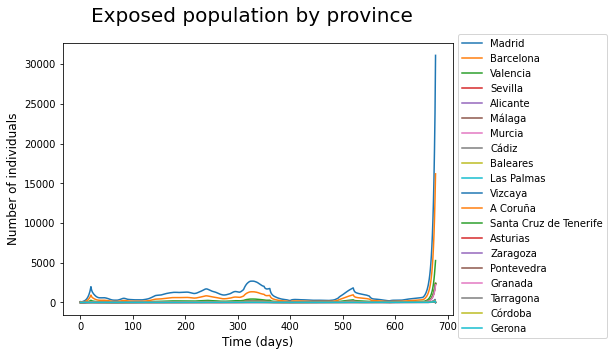

In [21]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

# Set titles
fig.suptitle('Exposed population by province', size=20)

# We plot all infections, both from our predictions and from our "ground truth" data
for i in range(len(df)):
    ax.plot(range(678), df['E'][i], label=f"{df['Provincia'][i]}")
    
# Set axis labels
ax.set_ylabel("Number of individuals", size=12); ax.set_xlabel("Time (days)", size=12)

plt.legend(bbox_to_anchor=(1,1.05), loc="upper left") # Plot legend
plt.savefig("./susceptible-recovered.png", dpi=400)

Finally, we will repeat the cumulative, province-by-province graph for the no-mobility scenario:

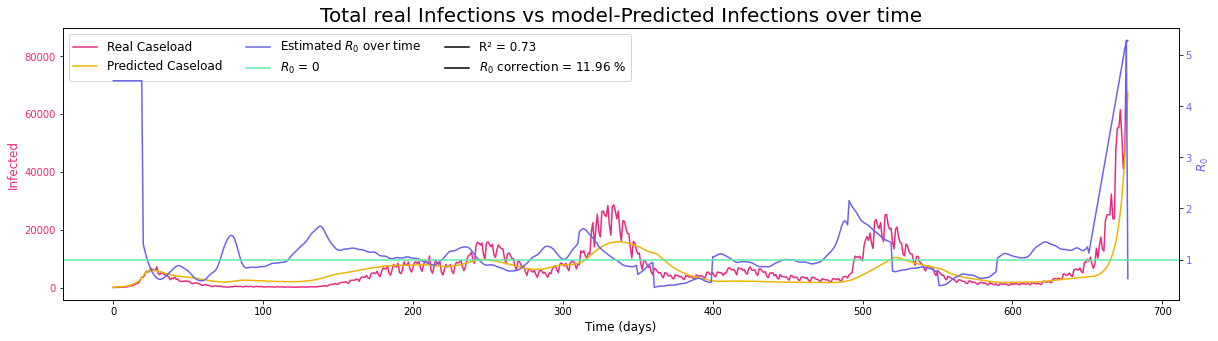

In [22]:
fig, ax = plt.subplots(1,1, figsize=(20,5))

ax.set_title('Total real Infections vs model-Predicted Infections over time', size=20)

# First plot
ax.set_xlabel("Time (days)", size=12); 
ax.plot(range(len(casos_totales[50:-10])), casos_totales[50:-10], '-', label='Real Caseload', color = "#E32C80")
ax.plot(range(len(casos_totales[50:-10])), new_infectados_totales, '-', label='Predicted Caseload', color = "#ecb400")
ax.set_ylabel("Infected", color="#E32C80", size=12)
ax.tick_params(axis='y', labelcolor="#E32C80")

res = stats.linregress(new_infectados_totales,casos_totales[50:-10])

# Second plot
ax1 = ax.twinx() #Should be done in the same fig
ax1.plot(range(len(casos_totales[50:-10])), estimated_r0["R_mean"], '-', 
         label='Estimated $R_{0}$ over time', color = "#6964EA")
ax1.tick_params(axis='y', labelcolor="#6964EA")
ax1.axhline(y=1,color="#64EAAC", label = "$R_{0}$ = 0")
ax1.set_ylabel("$R_{0}$", color="#6964EA", size=12)

# Custom legend colors
custom_legend = [Line2D([0], [0], color="#E32C80"), Line2D([0], [0], color="#ecb400"),
                Line2D([0], [0], color="#6964EA"), Line2D([0], [0], color="#64EAAC"), 
                Line2D([0], [0], color="black"), Line2D([0], [0], color="black")]

# Custom legend labels
ax.legend(custom_legend, ['Real Caseload', 'Predicted Caseload', 'Estimated $R_{0}$ over time', 
                          '$R_{0}$ = 0', f'R² = {round(res.rvalue**2, 3)}', 
                          f'$R_{0}$ correction = {correction} %'], ncol=3, prop=dict(size=12))

plt.savefig("./infections-over-time-noconnection.png", dpi=500)

And that's all folks :p